# **Group 21 - Report**
# *Introduction to Artificial Intelligence IN3062*

# **Introduction**

We decided to opt for a unique dataset that was not found to be studied online, while also providing a problem domain that could be approached with both binary classification and regression models. As such, we decided on a dataset for `Occupancy Detection` that contained continuous real data for regression and a binary problem domain for classification, its variables being:

| Variable Name | Units | Data type |
| --- | --- | --- |
| ID | N/A | Integer |
| Temperature | Celcius | Real |
| Humidity | Relative % | Real |
| Light | Lux | Real |
| CO2 | ppm | Real |
| Humidity Ratio | Kilogram (water vapour) / Kilogram (air) | Real |
| Occupancy | N/A | Binary |

With this dataset we are studying the binary variable `Occupancy` with `0` the room is not occupied and `1` meaning the room is occupied. This data was collected using time stamped pictures of the ground at one minute intervals of each entry. The aim is to find which variable / combination of variables are most significant when it comes to determining whether a room will be occupied or not.
<br>

While it is very difficult to source a dataset that has not been studied at least a couple of times before, the dataset we have chosen only appears to have been cited once according to the 'UC Irvine Machine Learning Repository' (see markdown file) with the research paper itself being cited 490 times (see markdown file). Given that the original research was done using the R Programming Language, it seems suitable to be able to use this dataset to study using Python instead.

# **Preprocessing and Standardisation of Data**

The provided datasets `datatest.txt`, `datatest2.txt` and `datatraining.txt` all include problems which need to be addressed before they can be used by a baseline model, the problems being as follows.

**1)** The header line that contains the variable names for each of the files contains an inconsistency where an `ID` variable is not included and only the `date` variable is not capitalised, which should appear as `Date`. This is important to ensure there are no differences in the variable naming schemes and maintain uniformity.

**2)** The number of entries for each dataset are largely different from each other.

**3)** Some of the required datasets to be used are missing.

The current datasets have the following properties:

| File name | Number of entries | File size |
| --- | --- | --- |
| `datatest.txt` | 2665 | 198KB |
| `datatest2.txt` | 9752 | 692KB |
| `datatraining.txt` | 8143 | 590KB |

The required datasets that will be used are the training, testing and validation. However we only currently have the training and testing datasets but no validation dataset. As `datatest2.txt` is both the largest file and is significantly larger than `datatest.txt`, we will split it into the two desired parts, having the new `datatest2.txt` have the same number of entries as `datatest.txt` and the remainder will be used for a new `datavalidation.txt` file. To guarantee the randomness of the entries for each new file for whether the variable `Occupancy` is a `0` or `1`, we will be shuffling the `datatest2.txt` file before splitting it. Inevitably, the `ID` variable will no longer be an incrementing variable for the text file as the entries have been shuffled. `datatest.txt` will also be renamed to `datatest2.txt` for clarity between the two testing datasets.

**4)** The training dataset requires a sufficient number of both positive and negative entries for `Occupancy`. To fix this, oversampling can be used with the SMOTE library (Synthetic Minority Oversampling Technique) which is used to produce similar artificial values for the minority so that the distribution becomes balanced.

Below is the program used to address the issues listed above:

In [8]:
import os, random
import pandas as pd

from pathlib import Path
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder


# --------------------------------------------------------------------------------------------


def fix_header(input_file):
    
    # Reading the file
    
    with open(input_file, 'r') as file:
        lines = file.readlines()
        
        # Split the headings line by the first comma delimiter
        
        parts = lines[0].split(',',1)
        
        # Reassign the first part and join
        
        parts[0] = '"ID","Date",'
        lines[0] = parts[0] + parts[1]
        
    # Writing to the file  
        
    with open(input_file, 'w') as file:
        file.writelines(lines)

    file.close()


def shuffle_and_split(input_file, split_count, first_output_dataset, second_output_dataset):

    # Open the file and read its contents
    
    with open(input_file, 'r') as file:
        lines = file.readlines()
        
    # Set the header line and the lines to be shuffled
    
    vars_header = lines[0]
    data_lines = lines[1:]
    
    # Shuffle the lines
    
    random.shuffle(data_lines)
    
    # Split the lines and make two different halves of the split index
    
    lines_datatest2 = [vars_header] + data_lines[:split_count]
    lines_datavalidation = [vars_header] + data_lines[split_count:]
    
    # Overwrite the old file name
    
    os.rename(input_file, "old_" + input_file)
    
    file.close()

    # Write the each set of lines to their output files
    
    with open(first_output_dataset, 'w') as dataset:
        dataset.writelines(lines_datatest2)
        dataset.close()
    
    with open(second_output_dataset, 'w') as dataset:
        dataset.writelines(lines_datavalidation)
        dataset.close()


def print_distribution(file, test_variable):

    # Read file
    
    df = pd.read_csv(file)
    
    # Find the sum of all 0s and 1s for each file
    
    count_0s = (df[test_variable] == 0).sum()
    count_1s = (df[test_variable] == 1).sum()
    
    # Print the differences
    
    print(f"Distribution of {file}\nTest variable: {test_variable}")
    print(f"Total 0s: {count_0s}\nTotal 1s: {count_1s}")
    
    # Calculate as a ratio
    
    perc_0s = round(((count_0s) / (count_0s + count_1s)) * 100, 2)
    perc_1s = round(((count_1s) / (count_0s + count_1s)) * 100, 2)
    
    print(f"Ratio (True:False) = {perc_1s}:{perc_0s}")


def smote_data(file):
    
    # Reading the file
    
    df = pd.read_csv(file)
    
    # Encoding the non-numeric entry date into a numeric datatype that can be used to SMOTE
    
    label_encoder = LabelEncoder()
    df['Date'] = label_encoder.fit_transform(df['Date'])
    
    # Drop columns

    X = df.drop(columns = 'Occupancy')
    y = df['Occupancy']

    # Resampling
    
    smote = SMOTE(random_state = 42)
    X_res, y_res = smote.fit_resample(X, y)

    # Overwriting the file
    
    df_resampled = pd.concat([X_res, y_res], axis=1)
    df_resampled.columns = df.columns
    df_resampled.to_csv(file, index = False, quoting = 1)


# --------------------------------------------------------------------------------------------


# Test if in the correct working directory, else change current working directory

cwd = Path().resolve()

if not (cwd / "src").is_dir():
    os.chdir(cwd.parent)

# Make the new usable directory and make the usable directory

os.chdir(cwd / "datasets")
cwd = Path().resolve()

if not (cwd / "usable").is_dir():
    os.mkdir("usable")
    print("Directory 'usable' created")

# Changing the name of 'datatest.txt'

if not (os.path.exists("datatest1.txt")) and (os.path.exists("datatest.txt")):
    os.rename("datatest.txt", "datatest1.txt")
    print("Dataset datatest.txt has been renamed")

# Declare the file variables

datatraining = ""
datatest1 = ""
datatest2 = ""
datavalidation = ""

# Iterate through all the files in the directory to fix header and assign to the file variables

for file in os.listdir(cwd):
    
    if (file == "datatest1.txt"):
        datatest1 = file
    elif (file == "datatest2.txt"):
        datatest2 = file
    elif (file == "datatraining.txt"):
        datatraining = file
    else:
        continue

    fix_header(file)
    print("Fixed header for file: " + file)

# Count the number of lines in datatest1.txt

dt1_lines = 0

# Minus 1 to exclude the variable header line

with open("datatest1.txt", 'r') as dt1:
    dt1_lines = len(dt1.readlines()) - 1
    dt1.close()

# Validation text file and output files

datavalidation = "datavalidation.txt"
ss_output_file1 = "datatest2.txt"

# Shuffle and split

shuffle_and_split(datatest2, dt1_lines, ss_output_file1, datavalidation)
print("File " + datatest2 + " has been split")

# Testing the balance of the training dataset

print("--------------------------------------------------")

print_distribution(datatraining, "Occupancy")

# Using SMOTE on the training dataset

smote_data(datatraining)

print("--------------------------------------------------")

print_distribution(datatraining, "Occupancy")

print("--------------------------------------------------")

# Moving the usable files to the usable directory

for file in os.listdir(cwd):

    # Testing if its a file or directory

    if (os.path.isdir(file)):
        continue

    # Testing if a file has been marked as "old" and moving files

    parts = ((file.split("."))[0]).split("_")

    if not (len(parts) > 1):
        os.replace(file, "usable/" + file)
        print("Moved file " + file + " to usable directory")
    else:
        continue

Directory 'usable' created
Dataset datatest.txt has been renamed
Fixed header for file: datatest1.txt
Fixed header for file: datatest2.txt
Fixed header for file: datatraining.txt
File datatest2.txt has been split
--------------------------------------------------
Distribution of datatraining.txt
Test variable: Occupancy
Total 0s: 6414
Total 1s: 1729
Ratio (True:False) = 21.23:78.77
--------------------------------------------------
Distribution of datatraining.txt
Test variable: Occupancy
Total 0s: 6414
Total 1s: 6414
Ratio (True:False) = 50.0:50.0
--------------------------------------------------
Moved file datatest1.txt to usable directory
Moved file datatest2.txt to usable directory
Moved file datatraining.txt to usable directory
Moved file datavalidation.txt to usable directory


c:\Users\Ridwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\Ridwan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


# **Metrics Used For AI Models**

There are a variety of metrics which can be used to evaluate a model's performance, based on the learning type. The following are the metrics that will be used to test our models for both classification and regression.
<br>

### **Classification:**

- **Accuracy:** The proportion of correct predictions over the total number of predictions.

  - Works well if the dataset is balanced.
  - Misleading for imbalanced datasets (e.g., 99% accuracy on a dataset with 99% negatives).
  - Higher is better

  $
  \text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total predictions}}
  $

<br>

- **Precision:** The proportion of true positive predictions among all positive predictions.
  - Important when false positives have high costs (e.g., spam detection).

  $
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $

<br>

- **Recall:** The proportion of true positives among all actual positives.
  - Also known as sensitivity (true positive rate).
  - Crucial when false negatives are costly (e.g., medical diagnoses).

  $
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $

<br>

- **F1-Score:** The mean of precision and recall.
  - A good model has a balanced precision and recall.

  $
  F_1\text{-}score = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
  $

<br>

**Classification Metric Relationships:**

The values returned by the metrics can also affect one another.

**1) Precision vs Recall**
- Inversely proportional to each other in an imbalanced dataset.
- If high precision but low recall, suggests the model predicts positive only when very certain.
- If low precision but high recall, suggets the model predicts too many false positives.
- The F1-score balances this trade off, and will reflect the imbalance between precision and recall.

**2) Accuracy vs Precision/Recall**
- Accuracy does not always correlate with precision or recall in an imbalanced dataset.
<br>

### **Regression:**

- **Mean Absolute Error (MAE):** The average of all the errors.
  - Used to compare predicted versus observed values.

  $
  \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
  $

<br>

- **Mean Squared Error (MSE):** The average squared difference between predicted and actual values.
  - Emphasises large errors (due to squaring).
  - Penalises larger errors more heavily than MAE.
  
  $
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  $

<br>

- **Root Mean Squared Error (RMSE):** The square root of MSE.
  - Provides error in the original units.
  - Penalises large errors and maintain interpretability.

  $
  \text{RMSE} = \sqrt{\text{MSE}}
  $

<br>

- **R-Squared Score:** Proportion of variance compared to the baseline.
  - Coefficient of determination.
  - Indicates how well the model fits the data.
  - Indicates overall model fit, the closer to 1 the better.
  
  $
  R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
  $

<br>

**Regression Metric Relationships:**

The values returned by the metrics can also affect one another.

**1) MAE vs MSE**
- MAE penalises errors more heavily than MSE does.
- If the MSE is much larger than the MAE, it suggests the presence of large outliers
- If the MAE and MSE are close, it suggests that the errors are consistent.

**2) R-Squared Score vs MAE/MSE**
- R-Squared measures variance while MAE and MSE only measure the magnitude of errors.
- If high R-Squared and high MAE/MSE, suggests predictions deviate significantly from actual values despite capturing variance trends.
- If low R-Squared and low MAE/MSE, suggests predictions are close to actual values but the model provides little variance.

# **Baseline Model Testing on the Training Dataset**

For the baseline model we will be using logistic regression, a simple model to establish a basic performance benchmark before exploring more advanced machine learning models. Logistic Regression is a classification algorithm that predicts the probability of an instance belonging to a specific class (e.g., Occupied or Not Occupied). It uses a logistic (sigmoid) function to ensure predictions fall between 0 and 1. A threshold is applied to classify the instance into one of the classes. This makes it an effective and interpretable starting point for binary classification tasks.

For this model, we selected `Occupancy` as the target variable and used the selected variables as the input: `Temperature`, `Humidity`, `Light`, `CO2`, and `HumidityRatio`. To train the model we will be using the provided `datatraining.txt`, and both `datatest1.txt` and `datatest2.txt` as the test datasets. By using two different test datasets we can compare the results provided to get an idea of how the model performs on different data. As this is a classification task, the metrics accuracy, precision, recall and f1-score will all be used to measure the performance of the model.


///////

The confusion matrix provides a detailed breakdown of the model's predictions. It shows that the model correctly identified 1,262 "Not Occupied" instances and 342 "Occupied" instances. The model misclassified only 4 "Occupied" instances as "Not Occupied" (false negatives) and 21 "Not Occupied" instances as "Occupied" (false positives).

These results indicate that the baseline Logistic Regression model performed exceptionally well, with high accuracy, precision, recall, and F1-score. The confusion matrix further reinforces the model's ability to effectively distinguish between occupied and unoccupied states.

Next, we explored hyperparameter tuning for the Logistic Regression model to see if we could further improve its performance. We experimented with adjusting the regularization strength (C parameter) and the maximum number of iterations (max_iter) to find the optimal configuration.

After trying different hyperparameter combinations, we found that increasing the max_iter parameter to 1,000 helped the model converge more effectively, leading to a slight improvement in the metrics.

While the baseline Logistic Regression model already performed exceptionally well, the hyperparameter tuning helped us further optimize its performance, leading to a marginally higher accuracy, precision, recall, and F1-score.

These results provided a solid starting point for our analysis and gave us confidence in the dataset and the problem domain. We then proceeded to explore more advanced AI techniques, such as decision trees, support vector machines, and neural networks, to see if we could achieve even better performance.

-----------------------------------------------------
datatest1.txt results:
Accuracy: 0.9786
Precision: 0.9463
Recall: 0.9979
F1 Score: 0.9715
-----------------------------------------------------
datatest2.txt results:
Accuracy: 0.9899
Precision: 0.9651
Recall: 0.9898
F1 Score: 0.9773
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1693
           1       0.95      1.00      0.97       972

    accuracy                           0.98      2665
   macro avg       0.97      0.98      0.98      2665
weighted avg       0.98      0.98      0.98      2665

-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2079
           1       0.97      0.99      0.98       586

    accuracy                           0.99      2665
   macro avg       0.98      0.99      0.99      2665
weigh

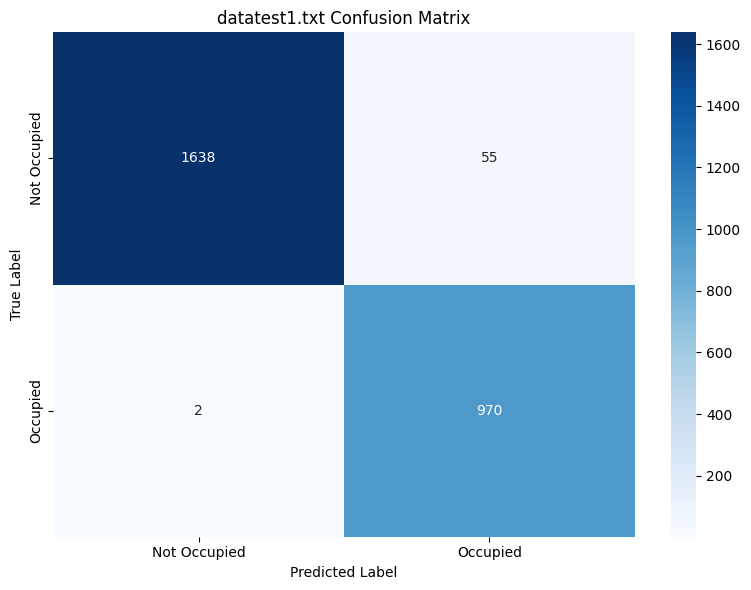

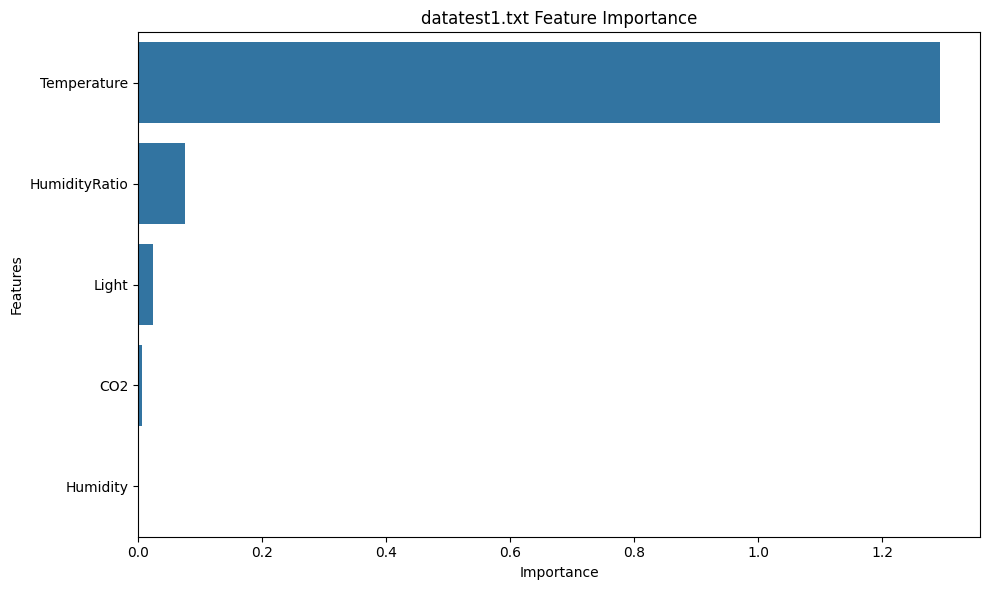

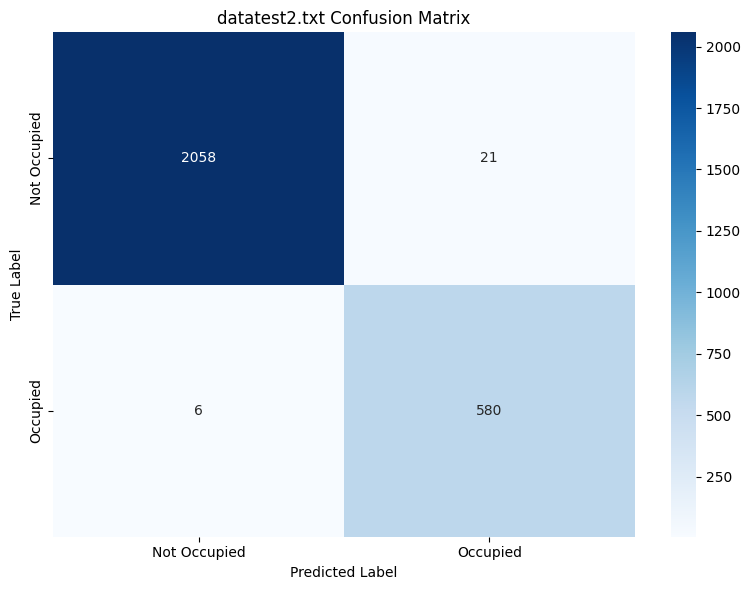

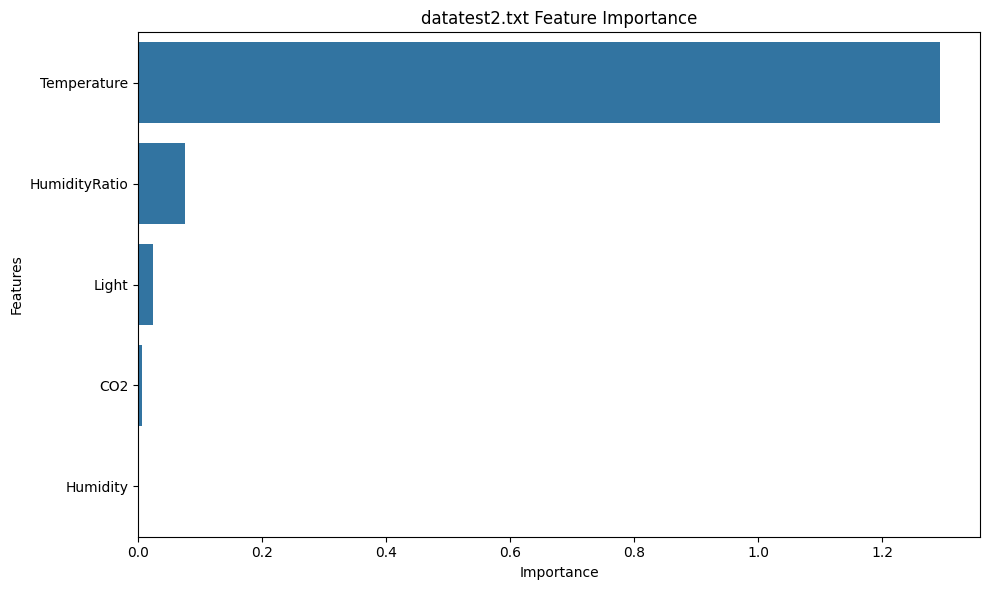

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix, 
    classification_report
)

# --------------------------------------------------------------------------------------------


def load_data(filepath):
    df = pd.read_csv(filepath)
    
    # Select features (excluding ID and Date)

    features = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
    
    X = df[features]
    y = df['Occupancy']
    
    return X, y


def train_logistic_regression(X_train, y_train):
    model = LogisticRegression(
        random_state=42
    )
    model.fit(X_train, y_train)
    return model


def evaluate_model(model, X_test, y_test):

    # Predictions
    
    y_pred = model.predict(X_test)
    
    # Metrics
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    
    return metrics, y_pred


def print_metrics(dataset_name, metrics):

    print(f"{dataset_name} results:")

    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


def plot_confusion_matrix(dataset_name, y_test, y_pred):

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Occupied', 'Occupied'],
                yticklabels=['Not Occupied', 'Occupied'])
    
    plt.title(f'{dataset_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()


def plot_feature_importance(dataset_name, feature_names):

    plt.figure(figsize=(10, 6))
    coefficients = model.coef_[0]

    feature_importance = pd.Series(
        np.abs(coefficients), 
        index=feature_names
    ).sort_values(ascending=False)
    
    sns.barplot(x=feature_importance.values, y=feature_importance.index)
    plt.title(f'{dataset_name} Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()


# --------------------------------------------------------------------------------------------


# Test if in the correct working directory, else change current working directory

cwd = Path().resolve()

if not (cwd / "src").is_dir():
    os.chdir(cwd.parent)

# Move to the datasets directory and make the usable directory

os.chdir(cwd / "datasets/usable")
cwd = Path().resolve()

# Name the datasets

training = "datatraining.txt"
testing1 = "datatest1.txt"
testing2 = "datatest2.txt"

# Load the training dataset

X_train, y_train = load_data(cwd / training)

# Load the testing datasets

X_test1, y_test1 = load_data(cwd / testing1)
X_test2, y_test2 = load_data(cwd / testing2)

# Train the model

model = train_logistic_regression(X_train, y_train)

# Evaluate model

metrics1, y_pred1 = evaluate_model(model, X_test1, y_test1)
metrics2, y_pred2 = evaluate_model(model, X_test2, y_test2)

"""
# Prepare the data
X_train, X_test, y_train, y_test = prepare_data(X, y)

# Train the model
model = train_logistic_regression(X_train, y_train)

# Evaluate model
metrics, y_pred = evaluate_model(model, X_test, y_test)
"""

# Print test metrics

print("-----------------------------------------------------")

print_metrics(testing1, metrics1)

print("-----------------------------------------------------")

print_metrics(testing2, metrics2)

print("-----------------------------------------------------")

# Print detailed classification report

print(classification_report(y_test1, y_pred1))

print("-----------------------------------------------------")

print(classification_report(y_test2, y_pred2))

print("-----------------------------------------------------")

# Visualizations

plot_confusion_matrix(testing1, y_test1, y_pred1)
plot_feature_importance(testing1, X_test1.columns)

plot_confusion_matrix(testing2, y_test2, y_pred2)
plot_feature_importance(testing2, X_test2.columns)

As seen in the metrics from both `datatest1.txt` and `datatest2.txt`, the model is predicting the vast majority of the testing datasets correctly with `Temperature` being the overwhelming contributer to predictions. For both the datasets, all of the metrics scored at least a `0.95`, meaning the datasets are far too simple and lack outliers.

To fix this, outliers can be deliber

In [2]:
import random, os

from pathlib import Path


# --------------------------------------------------------------------------------------------


def generate_dirty_data(num_samples):

    # Define the realistic ranges for each of the variables

    r_temp_range = (18.0, 24.0)  # Temperature in Celsius
    r_humidity_range = (18.0, 45.0)  # Humidity in relative percentage
    r_light_range = (0.0, 530.0)  # Light in Lux
    r_co2_range = (350.0, 2000.0)  # CO2 in ppm
    r_humidity_ratio_range = (0.0025, 0.006)  # Humidity ratio

    # Define the extreme ranges for each of the variables

    ur_temp_range = (5.0, 35.0)  # Temperature in Celsius
    ur_humidity_range = (0.0, 70.0)  # Humidity in relative percentage
    ur_light_range = (0.0, 650.0)  # Light in Lux
    ur_co2_range = (50.0, 3000.0)  # CO2 in ppm
    ur_humidity_ratio_range = (0.002, 0.007)  # Humidity ratio

    # Array to hold entries

    data_rows = []

    # Generate the data

    for i in range(num_samples):

        id = f'"{random.randint(1, num_samples)}"'

        date = f'"{random.randint(1, num_samples)}"'

        temperature = round(random.uniform(*r_temp_range) if random.random() < 0.7 else random.uniform(*ur_temp_range), 5)

        humidity = round(random.uniform(*r_humidity_range) if random.random() < 0.7 else random.uniform(*ur_humidity_range), 5)

        light = round(random.uniform(*r_light_range) if random.random() < 0.7 else random.uniform(*ur_light_range), 2)

        co2 = round(random.uniform(*r_co2_range) if random.random() < 0.7 else random.uniform(*ur_co2_range), 2)

        humidity_ratio = round(random.uniform(*r_humidity_ratio_range) if random.random() < 0.7 else random.uniform(*ur_humidity_ratio_range), 10)

        occupancy = random.choice([0, 1])

        data_row = f'{id},{date},{temperature},{humidity},{light},{co2},{humidity_ratio},{occupancy}'
        data_rows.append(data_row)

    return data_rows


def insert_data(input_file, input_data, has_header, shuffle):

    # Open file and write lines

    with open(input_file, 'a') as file:
        for line in input_data:
            file.write(f"{line}\n")
    
        file.close()

    if (shuffle):

        # Shuffle data

        with open(input_file, 'r+') as file:
            lines = file.readlines()

            # Ignore header

            if (has_header):
                vars_header = lines[0]
                data_lines = lines[1:]

                random.shuffle(data_lines)

                for line in data_lines:
                    file.write(f"{line}")

            else:
                random.shuffle(lines)

                for line in data_lines:
                    file.write(f"{line}")
            
            file.close()    


# --------------------------------------------------------------------------------------------


# Test if in the correct working directory, else change current working directory

cwd = Path().resolve()

if not (cwd / "src").is_dir():
    os.chdir(cwd.parent)

os.chdir(cwd / "datasets/usable")
cwd = Path().resolve()

# Generate the dirty data

samples = 10000
dirty_data = generate_dirty_data(samples)

# Save dirty data to file and shuffle

file = "datatraining.txt"

insert_data(file, dirty_data, True, True)

print("Successfully inserted dirty data")

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\don00\\Desktop\\Uni Github Work\\IN3062-AI-Coursework\\report\\datasets\\usable'

## **Chosen Models**

This section describes the classification and regression models selected for analyzing the Occupancy Detection Dataset from the UCI repository and evaluates their suitability based on the dataset characteristics.

#### Classification Models
The goal of classification models is to determine whether a room is "Occupied" (1) or "Not Occupied" (0) based on features such as temperature, humidity, light levels, CO₂ levels, and humidity ratio. These are binary classification tasks.

##### K-Nearest Neighbors (KNN)
KNN is a non-parametric, instance-based learning algorithm that predicts the class of a test sample based on the majority class of its nearest neighbors. The distance between data points (e.g., Euclidean distance) is a key factor.

Strengths:
- Simple and intuitive; no assumptions about data distribution.
- Effective for smaller datasets or when the decision boundary is complex and non-linear.

Weaknesses:
- Computationally expensive for larger datasets since predictions require calculating distances to all training points.
- Sensitive to irrelevant or noisy features, which may affect distance calculations.

##### Support Vector Machine (SVC)
SVM constructs hyperplanes in a high-dimensional space to separate data points into classes. With kernels like radial basis function (RBF), SVC can efficiently handle non-linear decision boundaries.

Strengths:
- Effective for high-dimensional spaces and non-linearly separable data.
- Robust to overfitting when using a proper regularization parameter (C).

Weaknesses:
- Computationally expensive for large datasets due to its reliance on support vectors.
- Hyperparameter tuning (e.g., C, gamma, and kernel) can be complex.

#### Regression Model
The regression model addresses the possibility of treating room occupancy as a continuous variable (e.g., modeling environmental factors influencing room usage levels).

##### Random Forest
Random Forest is an ensemble learning method that builds multiple decision trees during training and outputs the average prediction for regression tasks. It inherently captures non-linear relationships between features and the target variable.

Strengths:
- Handles large datasets and works well with high-dimensional and correlated features.
- Provides feature importance, aiding in understanding the drivers of predictions.
- Less prone to overfitting compared to single decision trees due to ensemble averaging.

Weaknesses:
- Computationally expensive with many trees or deep trees.
- May be less interpretable than simpler models like linear regression.

#### **Dataset Suitability and Model Alignment**
The Occupancy Detection Dataset contains environmental sensor data with:
- Numerical Features: Continuous features (e.g., Temperature, Humidity, CO₂, etc.).
- Binary Target: Occupancy (1 = Occupied, 0 = Not Occupied).

Given the dataset’s characteristics:
##### Classification Models (KNN, SVC) are well-suited because:
The dataset contains binary labels, making it ideal for classification techniques.
KNN handles non-linear relationships in a straightforward way.
SVC provides robust performance with non-linear decision boundaries (e.g., rbf kernel).
##### Regression Model (Random Forest) can be applied creatively to predict probabilities or continuous labels for room usage:
Environmental variables like CO₂ levels may influence room occupancy as continuous signals, justifying regression analysis.
Random Forest handles feature interactions and provides insights into feature importance.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    confusion_matrix,
    mean_squared_error, 
    r2_score
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path


# Test if in the correct working directory

cwd = Path().resolve()

if not (cwd / "src").is_dir():
    os.chdir(cwd.parent)

# Load the data
def load_data(filepath):
    df = pd.read_csv(filepath)
    
    # Select features (excluding ID and Date)
    features = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
    
    X = df[features]
    y = df['Occupancy']
    
    return X, y

# Prepare data
def prepare_data(X, y, test_size=0.2, random_state=42):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test

# Train KNN
def train_knn(X_train, y_train, n_neighbors=5, weights='uniform', p=2):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, p=p)
    knn.fit(X_train, y_train)
    return knn


# Train SVC
def train_svc(X_train, y_train, kernel='linear', C=1.0, gamma='scale'):
    svc = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, random_state=42)
    svc.fit(X_train, y_train)
    return svc

# Train Random Forest (regression)
def train_random_forest(X_train, y_train, n_estimators=100):
    rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    rf.fit(X_train, y_train)
    return rf

# Evaluate classification model
def evaluate_classification_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    
    return metrics, y_pred

# Evaluate regression model
def evaluate_regression_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'MSE': mse, 'R2': r2}, y_pred

# Plot confusion matrix
def plot_confusion_matrix(y_test, y_pred, title):
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Not Occupied', 'Occupied'],
                yticklabels=['Not Occupied', 'Occupied'])
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Plot feature importance
def plot_feature_importance(model, feature_names):
    plt.figure(figsize=(10, 6))
    importances = model.feature_importances_
    feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
    sns.barplot(x=feature_importance.values, y=feature_importance.index)
    plt.title('Feature Importance in Random Forest')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()


# Load dataset
X, y = load_data('datasets/usable/datatraining.txt')

# Prepare data
X_train, X_test, y_train, y_test = prepare_data(X, y)

### **K-Nearest Neighbors (KNN)**

Key Hyperparameters:

- n_neighbors: Number of neighbors to consider for classification.
  - Small values (e.g., 1-5) can lead to overfitting, while large values (e.g., 20+) may underfit.
- weights: How neighbors contribute to the prediction (uniform vs. distance).
  - uniform: All neighbors are equally weighted.
  - distance: Closer neighbors have more influence.
- p: Distance metric.

KNN Metrics:
{'Accuracy': 0.8166161476990906, 'Precision': 0.7536667920270779, 'Recall': 0.7477611940298508, 'F1 Score': 0.7507023787226073}


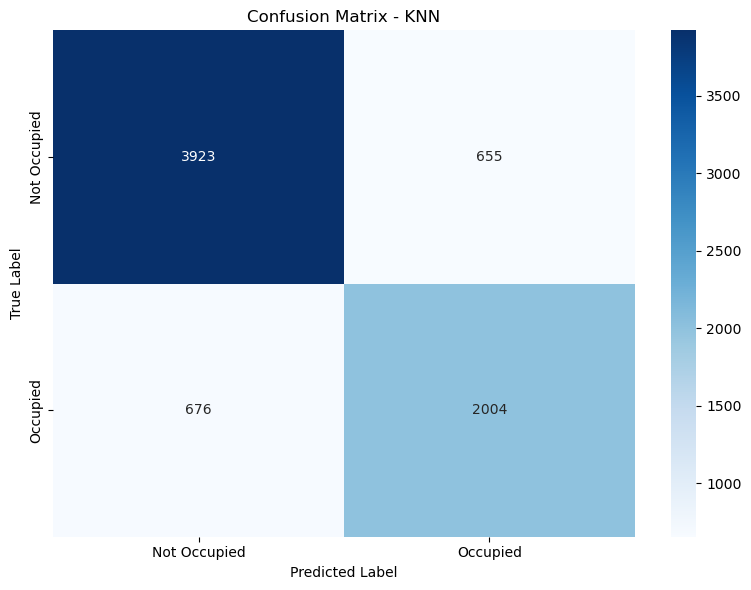

In [4]:
# KNN
knn_model = train_knn(X_train, y_train)
knn_metrics, knn_preds = evaluate_classification_model(knn_model, X_test, y_test)
print("KNN Metrics:")
print(knn_metrics)
plot_confusion_matrix(y_test, knn_preds, "KNN")

#### **Testing K-Nearest Neighbors (KNN)**

##### Base: With base Hyperparameters
- Default: n_neighbors=5, weights='uniform', p=2
- Metrics:
    - Accuracy: 0.8166
    - Precision: 0.7537
    - Recall: 0.7478
    - F1 Score: 0.7507

Observation: The base model with default hyperparameters shows decent performance but struggles slightly due to the presence of dirty data. Further tuning might mitigate this issue or confirm its robustness.

##### Test 1: Tweaking n_neighbors
- Tested Values: n_neighbors=3, 6, 9
- Metrics:
    - `n_neighbors=3`:
      - Accuracy: 0.7705
      - Precision: 0.6925
      - Recall: 0.6806
      - F1 Score: 0.6865
    - `n_neighbors=6`:
      - Accuracy: 0.7873
      - Precision: 0.7568
      - Recall: 0.6246
      - F1 Score: 0.6844
    - `n_neighbors=9`:
      - Accuracy: 0.7758
      - Precision: 0.6928
      - Recall: 0.7060
      - F1 Score: 0.6993
- Observation: Using `n_neighbors=6` yielded slightly higher precision but at the cost of recall. Meanwhile, `n_neighbors=3` had the highest recall but struggled with precision, likely due to overfitting on noise in the dirty dataset. A balanced choice may depend on the specific application needs.

##### Test 2: Tweaking weights
- Tested Values: weights='distance'
- Metrics:
    - Accuracy: 0.9493
    - Precision: 0.9366
    - Recall: 0.9254
    - F1 Score: 0.9309
- Observation: Changing the weight parameter to `distance` significantly improved all metrics, indicating that weighting neighbors by their proximity helps mitigate the effects of dirty data. This configuration effectively boosts the model's ability to classify edge cases where nearby points dominate the decision boundary.

KNN Metrics Base:
{'Accuracy': 0.8166161476990906, 'Precision': 0.7536667920270779, 'Recall': 0.7477611940298508, 'F1 Score': 0.7507023787226073}


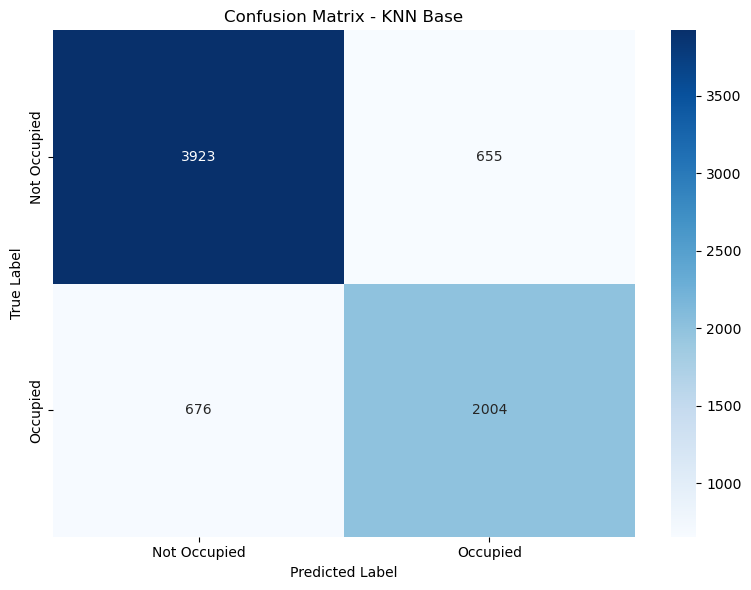

KNN Metrics Test 1 - n_neighbors 3:
{'Accuracy': 0.7704601818682832, 'Precision': 0.6924829157175398, 'Recall': 0.6805970149253732, 'F1 Score': 0.6864885208882198}


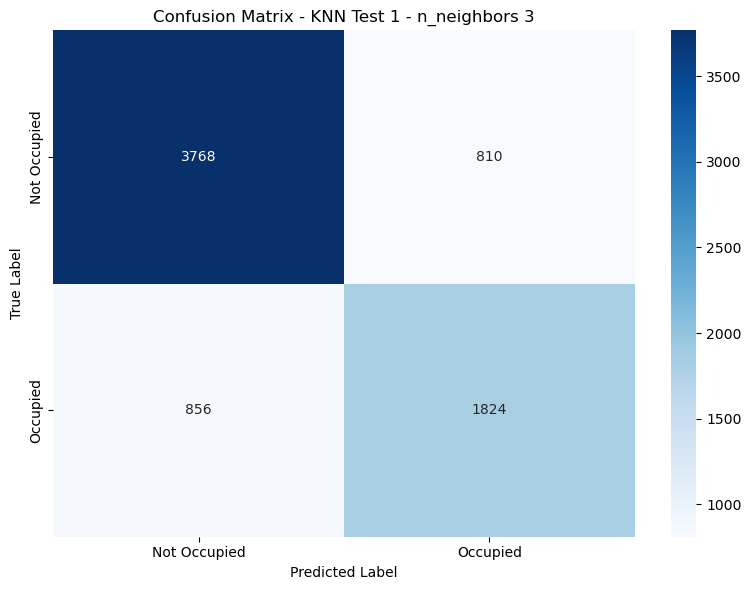

KNN Metrics Test 1 - n_neighbors 6:
{'Accuracy': 0.787269220170846, 'Precision': 0.7567811934900542, 'Recall': 0.6246268656716418, 'F1 Score': 0.6843826655764513}


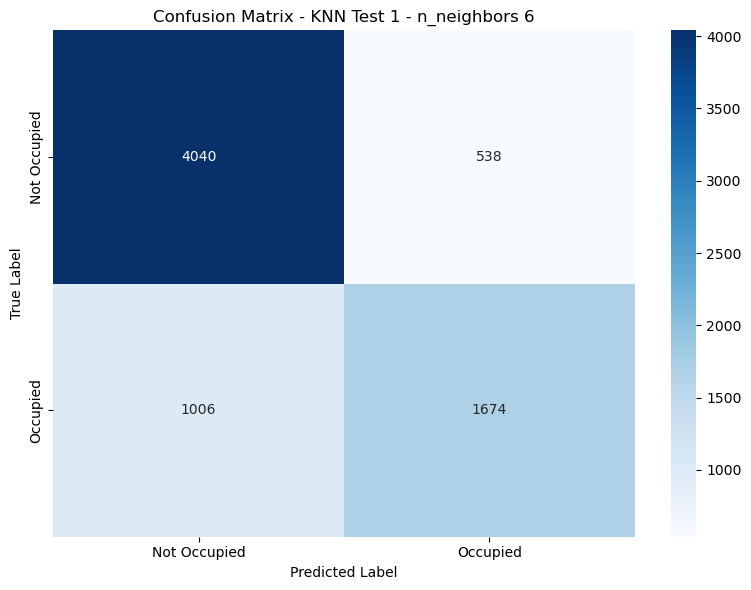

KNN Metrics Test 1 - n_neighbors 9:
{'Accuracy': 0.7758335629650042, 'Precision': 0.6927865250823874, 'Recall': 0.7059701492537314, 'F1 Score': 0.6993162077250046}


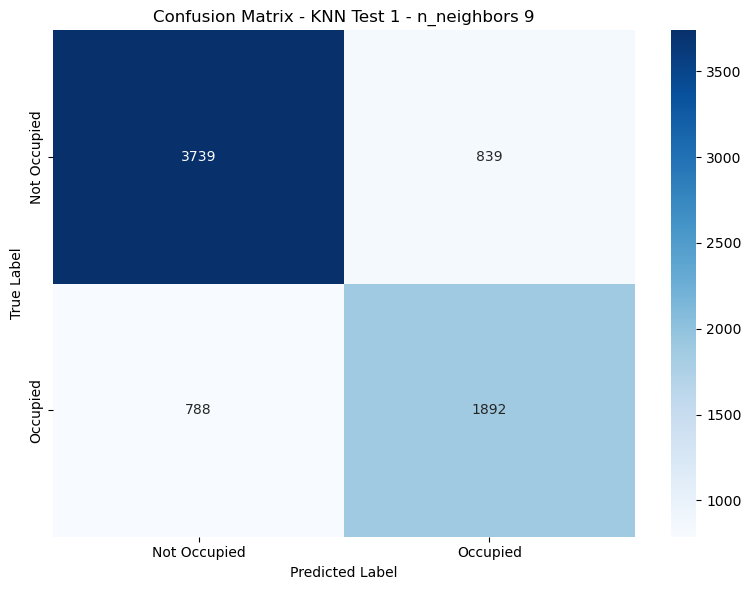

KNN Metrics Test 2 - weight = distance:
{'Accuracy': 0.9492973270873519, 'Precision': 0.9365558912386707, 'Recall': 0.9253731343283582, 'F1 Score': 0.9309309309309309}


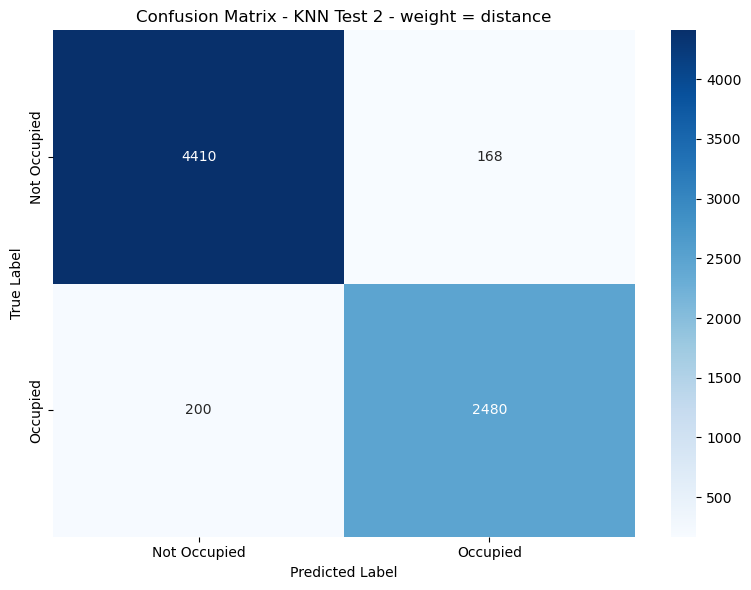

In [ ]:
# KNN Base
knn_model_base = train_knn(X_train, y_train)
knn_metrics_base, knn_preds_base = evaluate_classification_model(knn_model_base, X_test, y_test)
print("KNN Metrics Base:")
print(knn_metrics_base)
plot_confusion_matrix(y_test, knn_preds_base, "KNN Base")

# KNN Test 1 - n_neighbors 3
knn_model_test_1 = train_knn(X_train, y_train, 3)
knn_metrics_test_1, knn_preds_test_1 = evaluate_classification_model(knn_model_test_1, X_test, y_test)
print("KNN Metrics Test 1 - n_neighbors 3:")
print(knn_metrics_test_1)
plot_confusion_matrix(y_test, knn_preds_test_1, "KNN Test 1 - n_neighbors 3")

# KNN Test 1 - n_neighbors 6
knn_model_test_1 = train_knn(X_train, y_train, 6)
knn_metrics_test_1, knn_preds_test_1 = evaluate_classification_model(knn_model_test_1, X_test, y_test)
print("KNN Metrics Test 1 - n_neighbors 6:")
print(knn_metrics_test_1)
plot_confusion_matrix(y_test, knn_preds_test_1, "KNN Test 1 - n_neighbors 6")

# KNN Test 1 - n_neighbors 9
knn_model_test_1 = train_knn(X_train, y_train, 9)
knn_metrics_test_1, knn_preds_test_1 = evaluate_classification_model(knn_model_test_1, X_test, y_test)
print("KNN Metrics Test 1 - n_neighbors 9:")
print(knn_metrics_test_1)
plot_confusion_matrix(y_test, knn_preds_test_1, "KNN Test 1 - n_neighbors 9")

# KNN Test 2
knn_model_test_2 = train_knn(X_train, y_train, 5,  'distance')
knn_metrics_test_2, knn_preds_test_2 = evaluate_classification_model(knn_model_test_2, X_test, y_test)
print("KNN Metrics Test 2 - weight = distance:")
print(knn_metrics_test_2)
plot_confusion_matrix(y_test, knn_preds_test_2, "KNN Test 2 - weight = distance")

### **Support Vector Machine (SVC)**

Key Hyperparameters:

- C: Regularization parameter.
    - Small values make the classifier tolerant to errors (soft margin), preventing overfitting.
    - Large values focus on classifying every data point correctly (hard margin), risking overfitting.
- kernel: Specifies the kernel type for decision boundaries.
    - 'linear': Good for linearly separable data.
    - 'rbf': A popular choice for non-linear data.
    - 'poly': Fits polynomial decision boundaries.
- gamma: Controls the influence of individual data points (only for rbf, poly, sigmoid).
    - Small values create smoother decision boundaries (consider far points).
    - Large values create tighter boundaries (focus on near points).

SVC Metrics:
{'Accuracy': 0.6989528795811518, 'Precision': 0.5814948962792229, 'Recall': 0.658955223880597, 'F1 Score': 0.617806541892601}


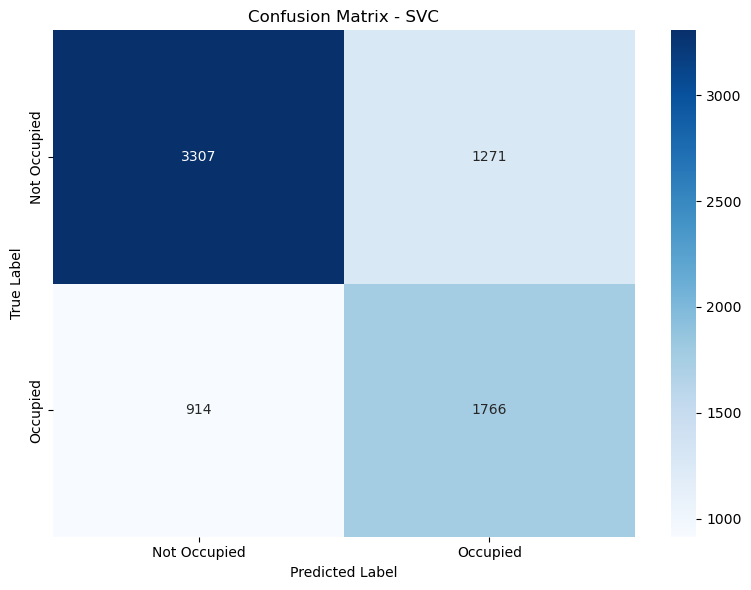

In [7]:
# SVC - Base
svc_model = train_svc(X_train, y_train)
svc_metrics, svc_preds = evaluate_classification_model(svc_model, X_test, y_test)
print("SVC Metrics:")
print(svc_metrics)
plot_confusion_matrix(y_test, svc_preds, "SVC")

##### Test 1: Tweaking C (Regularization)
- Tested Values: C= 0.1, 1, 10
- Metrics:
  - `C=0.1`:
    - Accuracy: 0.7260
    - Precision: 0.6707
    - Recall: 0.5070
    - F1 Score: 0.5775

  - `C=1`:
    - Accuracy: 0.7346
    - Precision: 0.6542
    - Recall: 0.5966
    - F1 Score: 0.6241

  - `C=10`:
    - Accuracy: 0.7458
    - Precision: 0.6587
    - Recall: 0.6466
    - F1 Score: 0.6526
- Observation: Increasing C reduces the penalty for misclassification, allowing the model to fit the data more closely. For this dataset, C=10 provides the best balance, as it achieves the highest metrics. However, further tuning or cross-validation might be needed to confirm the robustness of this choice.

SVC Metrics Test 1 - C = 0.1:
{'Accuracy': 0.7260953430697161, 'Precision': 0.6707798617966436, 'Recall': 0.5070895522388059, 'F1 Score': 0.5775605609859753}


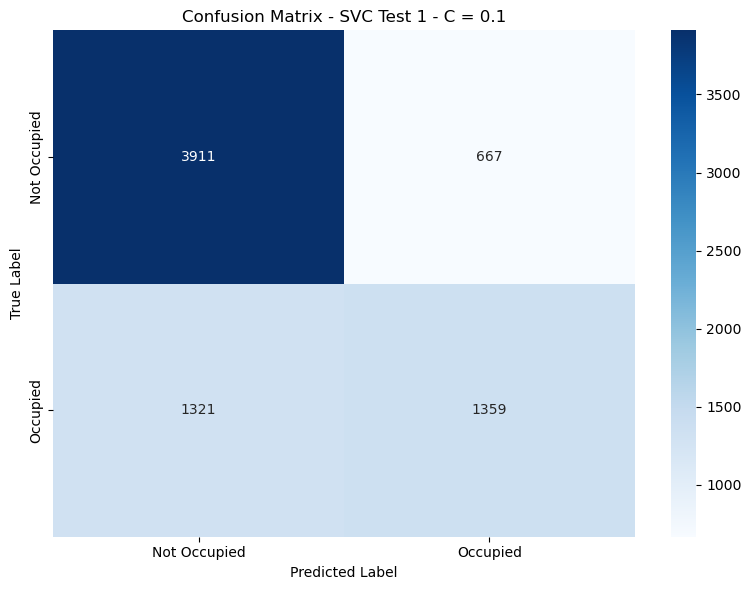

SVC Metrics Test 1 - C = 1:
{'Accuracy': 0.7346376412234775, 'Precision': 0.6542553191489362, 'Recall': 0.5966417910447761, 'F1 Score': 0.6241217798594848}


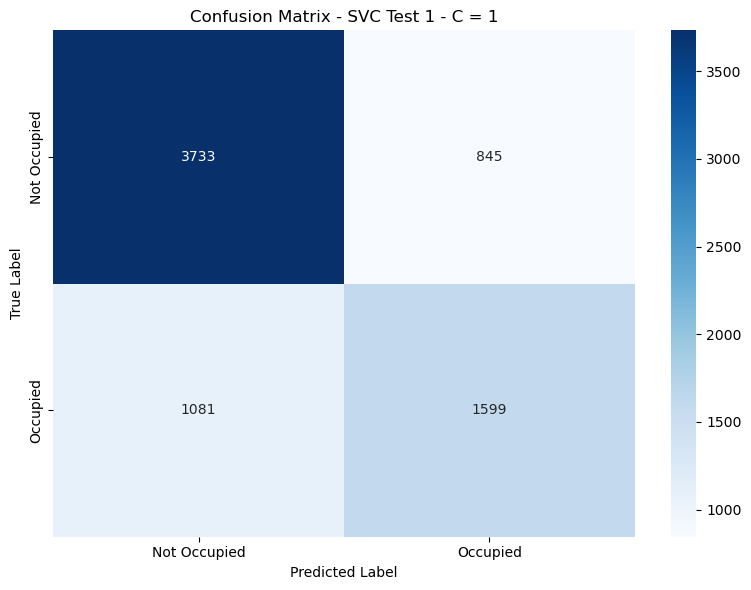

SVC Metrics Test 1 - C = 10:
{'Accuracy': 0.7457977404243593, 'Precision': 0.6586849106803496, 'Recall': 0.6466417910447761, 'F1 Score': 0.6526077951421578}


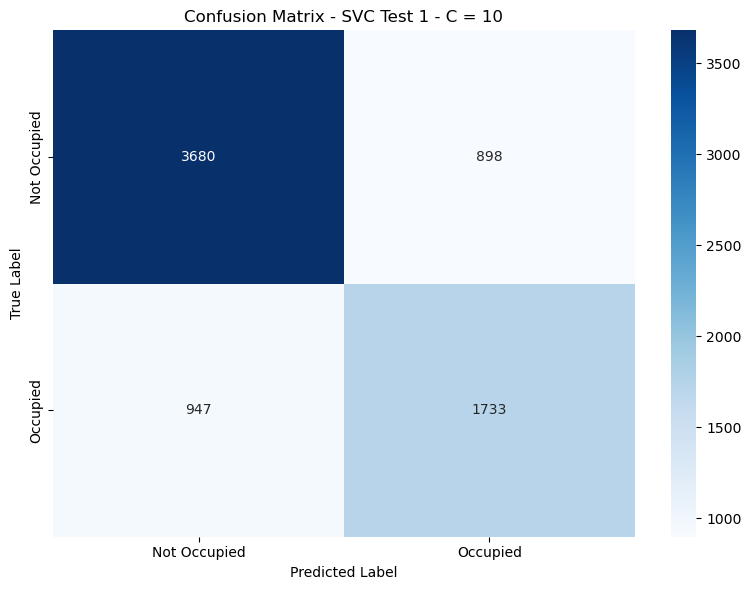

In [12]:
# SVC Test 1 - C = 0.1
svc_model_test_1 = train_svc(X_train, y_train, kernel='rbf', C=0.1, gamma='scale')
svc_metrics_test_1, svc_preds_test_1 = evaluate_classification_model(svc_model_test_1, X_test, y_test)
print("SVC Metrics Test 1 - C = 0.1:")
print(svc_metrics_test_1)
plot_confusion_matrix(y_test, svc_preds_test_1, "SVC Test 1 - C = 0.1")

# SVC Test 1 - C = 1
svc_model_test_1 = train_svc(X_train, y_train, kernel='rbf', C=1.0, gamma='scale')
svc_metrics_test_1, svc_preds_test_1 = evaluate_classification_model(svc_model_test_1, X_test, y_test)
print("SVC Metrics Test 1 - C = 1:")
print(svc_metrics_test_1)
plot_confusion_matrix(y_test, svc_preds_test_1, "SVC Test 1 - C = 1")

# SVC Test 1 - C = 10
svc_model_test_1 = train_svc(X_train, y_train, kernel='rbf', C=10, gamma='scale')
svc_metrics_test_1, svc_preds_test_1 = evaluate_classification_model(svc_model_test_1, X_test, y_test)
print("SVC Metrics Test 1 - C = 10:")
print(svc_metrics_test_1)
plot_confusion_matrix(y_test, svc_preds_test_1, "SVC Test 1 - C = 10")

##### Test 1: Tweaking Kernel
- Tested Values: kernel = 'linear', 'poly', 'rbf'
- Metrics:
    - `kernel='linear'`:
        - Accuracy: 0.6990
        - Precision: 0.5815
        - Recall: 0.6590
        - F1 Score: 0.6178

    - `kernel='poly'`:
        - Accuracy: 0.7103
        - Precision: 0.6762
        - Recall: 0.4131
        - F1 Score: 0.5129

    - `kernel='rbf'`:
        - Accuracy: 0.7346
        - Precision: 0.6543
        - Recall: 0.5966
        - F1 Score: 0.6241
- Observation: Increasing C reduces the penalty for misclassification, allowing the model to fit the data more closely. For this dataset, C=10 provides the best balance, as it achieves the highest metrics. However, further tuning or cross-validation might be needed to confirm the robustness of this choice.

SVC Metrics Test 2 - kernel = 'linear':
{'Accuracy': 0.6989528795811518, 'Precision': 0.5814948962792229, 'Recall': 0.658955223880597, 'F1 Score': 0.617806541892601}


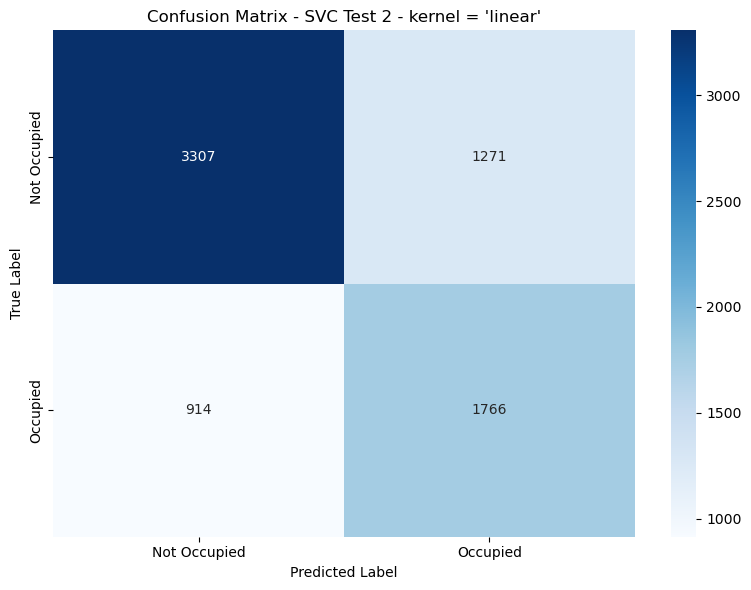

In [ ]:
# SVC Test 2 - kernel = 'linear'
svc_model_test_2 = train_svc(X_train, y_train, kernel='linear', C=1.0, gamma='scale')
svc_metrics_test_2, svc_preds_test_2 = evaluate_classification_model(svc_model_test_2, X_test, y_test)
print("SVC Metrics Test 2 - kernel = 'linear':")
print(svc_metrics_test_2)
plot_confusion_matrix(y_test, svc_preds_test_2, "SVC Test 2 - kernel = 'linear'")

# SVC Test 2 - kernel = 'poly'
svc_model_test_2 = train_svc(X_train, y_train, kernel='poly', C=1.0, gamma='scale')
svc_metrics_test_2, svc_preds_test_2 = evaluate_classification_model(svc_model_test_2, X_test, y_test)
print("SVC Metrics Test 2 - kernel = 'poly':")
print(svc_metrics_test_2)
plot_confusion_matrix(y_test, svc_preds_test_2, "SVC Test 2 - kernel = 'poly'")

# SVC Test 2 - kernel = 'rbf'
svc_model_test_2 = train_svc(X_train, y_train, kernel='rbf', C=1.0, gamma='scale')
svc_metrics_test_2, svc_preds_test_2 = evaluate_classification_model(svc_model_test_2, X_test, y_test)
print("SVC Metrics Test 2 - kernel = 'rbf':")
print(svc_metrics_test_2)
plot_confusion_matrix(y_test, svc_preds_test_2, "SVC Test 2 - kernel = 'rbf'")

SVC Metrics Test 3 - gamma = 0.01:
{'Accuracy': 0.6981262055662717, 'Precision': 0.5766217486681291, 'Recall': 0.6865671641791045, 'F1 Score': 0.626809742803611}


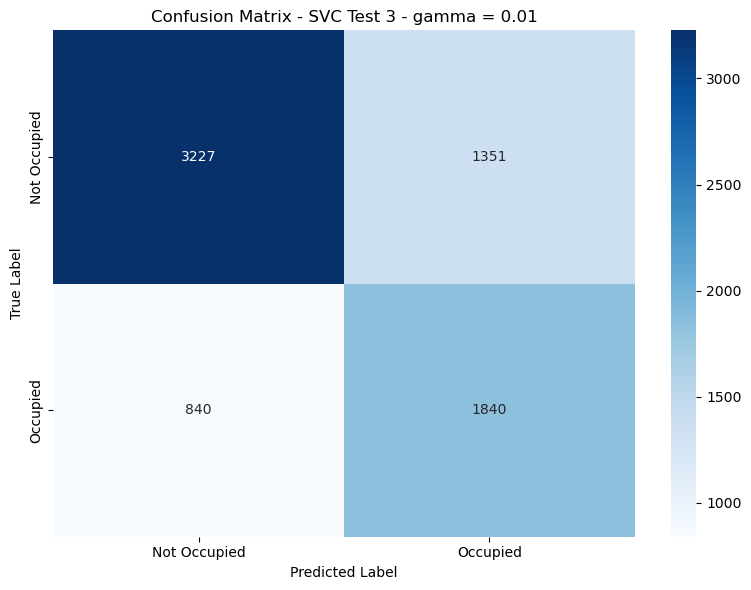

SVC Metrics Test 3 - gamma = 0.1:
{'Accuracy': 0.7292642601267567, 'Precision': 0.6540284360189573, 'Recall': 0.5664179104477612, 'F1 Score': 0.6070785842831433}


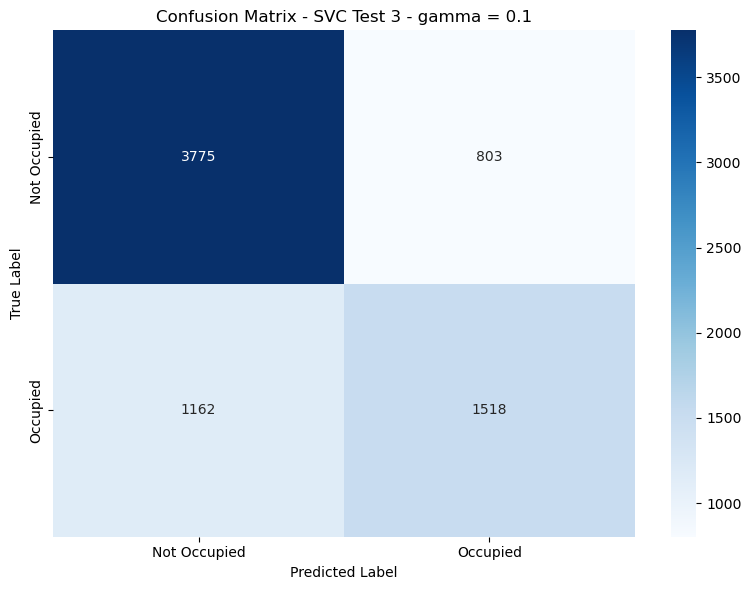

SVC Metrics Test 3 - gamma = 1:
{'Accuracy': 0.7894736842105263, 'Precision': 0.7128603104212861, 'Recall': 0.719776119402985, 'F1 Score': 0.7163015224656517}


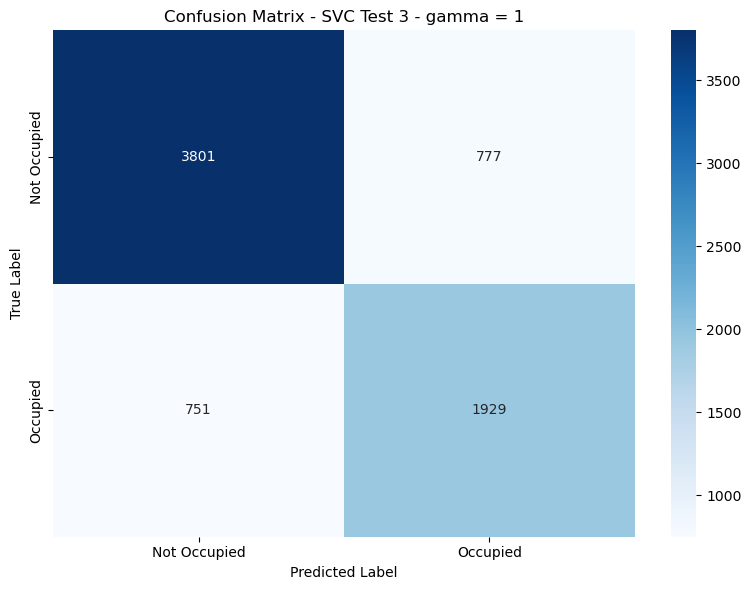

In [11]:
# SVC Test 3 - gamma = 0.01
svc_model_test_3 = train_svc(X_train, y_train, kernel='rbf', C=1.0, gamma=0.01)
svc_metrics_test_3, svc_preds_test_3 = evaluate_classification_model(svc_model_test_3, X_test, y_test)
print("SVC Metrics Test 3 - gamma = 0.01:")
print(svc_metrics_test_3)
plot_confusion_matrix(y_test, svc_preds_test_3, "SVC Test 3 - gamma = 0.01")

# SVC Test 3 - gamma = 0.1
svc_model_test_3 = train_svc(X_train, y_train, kernel='rbf', C=1.0, gamma=0.1)
svc_metrics_test_3, svc_preds_test_3 = evaluate_classification_model(svc_model_test_3, X_test, y_test)
print("SVC Metrics Test 3 - gamma = 0.1:")
print(svc_metrics_test_3)
plot_confusion_matrix(y_test, svc_preds_test_3, "SVC Test 3 - gamma = 0.1")

# SVC Test 3 - gamma = 1
svc_model_test_3 = train_svc(X_train, y_train, kernel='rbf', C=1.0, gamma=1)
svc_metrics_test_3, svc_preds_test_3 = evaluate_classification_model(svc_model_test_3, X_test, y_test)
print("SVC Metrics Test 3 - gamma = 1:")
print(svc_metrics_test_3)
plot_confusion_matrix(y_test, svc_preds_test_3, "SVC Test 3 - gamma = 1")

### **Random Forest Regression**

code + hyperparameter descriptions

tests + metric results + hyperparameter tweaking

repeat a couple of times

Random Forest Regression Metrics:
{'MSE': 0.045096527969137504, 'R2': 0.8063727614548488}


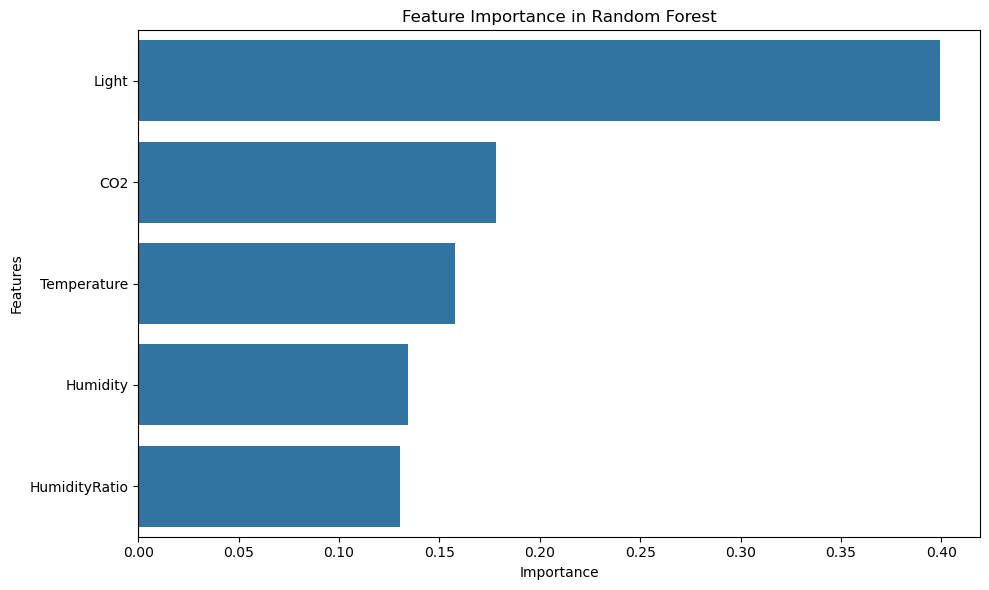

In [32]:
# Random Forest Regression
rf_model = train_random_forest(X_train, y_train)
rf_metrics, rf_preds = evaluate_regression_model(rf_model, X_test, y_test)
print("Random Forest Regression Metrics:")
print(rf_metrics)
plot_feature_importance(rf_model, X.columns)

## **Conclusion**

which method performed the best

what was gained in the trade offs for each one and how much did that benefit the model

what were the hyperparameters which made a big difference to the different models for each method

state which model overall was the most performant in forming a correct output